**@ Credits : Susan Li - Medium Post**

Autoencoders are an unsupervised learning technique, although they are trained using supervised learning methods. The goal is to minimize reconstruction error based on a loss function, such as the mean squared error.

we will try to detect anomalies in the Johnson & Johnson’s historical stock price time series data with an LSTM autoencoder.
The data can be downloaded from Yahoo Finance. The time period I selected was from 1985–09–04 to 2020–09–03.

The steps we will follow to detect anomalies in Johnson & Johnson stock price data using an LSTM autoencoder:

We will break down an LSTM autoencoder network to understand them layer-by-layer.

*   Train an LSTM autoencoder on the Johnson & Johnson’s stock price data from 1985–09–04 to 2013–09–03. We assume that there were no anomalies and they were normal.
*   Using the LSTM autoencoder to reconstruct the error on the test data from 2013–09–04 to 2020–09–03.
*   If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.





In [28]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('JNJ.csv')

In [19]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-02,2.242188,2.250000,2.218750,2.226563,0.095129,3361600
1,1985-01-03,2.226563,2.257813,2.195313,2.195313,0.093794,5819200
2,1985-01-04,2.203125,2.234375,2.195313,2.234375,0.095463,3787200
3,1985-01-07,2.242188,2.250000,2.234375,2.234375,0.095463,2508800
4,1985-01-08,2.242188,2.296875,2.242188,2.257813,0.096464,5800000
...,...,...,...,...,...,...,...
8999,2020-09-15,149.449997,150.589996,148.520004,148.889999,148.889999,3658800
9000,2020-09-16,149.389999,150.059998,148.350006,148.399994,148.399994,4323000
9001,2020-09-17,148.039993,148.630005,146.050003,147.169998,147.169998,5461400
9002,2020-09-18,146.509995,149.649994,146.199997,149.179993,149.179993,12174000


In [20]:
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('1985-01-02 00:00:00'), Timestamp('2020-09-21 00:00:00'))

In [21]:
#Visualise Time Series
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2020')
fig.show()

In [22]:
#PreProcessing
# Train Test Split
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']
train.shape, test.shape

((7229, 2), (1775, 2))

In [23]:
# Standardize the data
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

**Create sequences**

Convert input data into 3-D array combining *TIME_STEPS*. The shape of the array should be *[samples, TIME_STEPS, features]*, as required for LSTM network.

We want our network to have memory of 30 days, so we set *TIME_STEPS=30.*

In [24]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (7199, 30, 1)
Testing shape: (1745, 30, 1)


**Build the Model**

*   We define the reconstruction LSTM Autoencoder architecture that expects input sequences with 30 time steps and one feature and outputs a sequence with 30 time steps and one feature.

*  *RepeatVector()* repeats the inputs 30 times.
*  Set *return_sequences=True*, so the output will still be a sequence.
*  *TimeDistributed(Dense(X_train.shape[2]))* is added at the end to get the output, where *X_train.shape[2]* is the number of features in the input data.

In [25]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [26]:
# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
203/203 [==============================] - 13s 64ms/step - loss: 0.1336 - val_loss: 0.2041
Epoch 2/100
203/203 [==============================] - 12s 61ms/step - loss: 0.1001 - val_loss: 0.0883
Epoch 3/100
203/203 [==============================] - 12s 60ms/step - loss: 0.0686 - val_loss: 0.0371
Epoch 4/100
203/203 [==============================] - 12s 61ms/step - loss: 0.0646 - val_loss: 0.0266
Epoch 5/100
203/203 [==============================] - 12s 61ms/step - loss: 0.0663 - val_loss: 0.0243
Epoch 6/100
203/203 [==============================] - 12s 60ms/step - loss: 0.0653 - val_loss: 0.0307
Epoch 7/100
203/203 [==============================] - 12s 60ms/step - loss: 0.0717 - val_loss: 0.0766
Epoch 8/100
203/203 [==============================] - 12s 60ms/step - loss: 0.0704 - val_loss: 0.0301


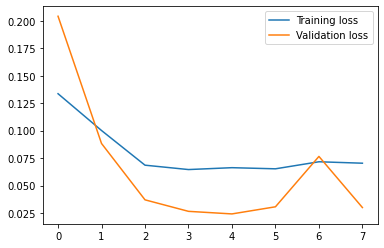

In [29]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [30]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 1s 17ms/step - loss: 0.1220


0.12196867913007736

**Determine Anomalies**

*   Find MAE loss on the training data.
*   Make the max MAE loss value in the training data as the reconstruction *error threshold.*
*   If the reconstruction loss for a data point in the test set is greater (">") than this *reconstruction error threshold* value then we will label this data point as an anomaly.

Reconstruction error threshold: 0.6350928196990651


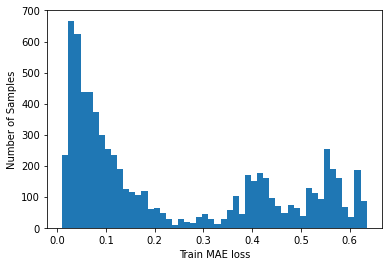

In [31]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

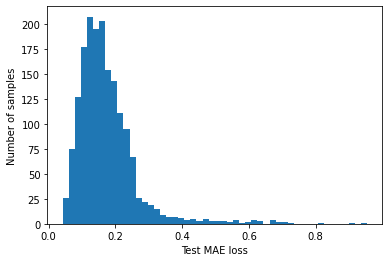

In [32]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [33]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [34]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(13, 5)

As you can see, there are **13** data points in the test set that exceeded the *reconstruction error threshold.*

In [35]:
# Visualize Anomalies
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()